# **GoogleNet**
此份程式碼會介紹如何使用 tf.keras 的方式建構 GoogleNet 的模型架構，以及訓練的方式。

<img src="https://i.imgur.com/g5fRr89.png" width=1000/>

- [source paper](https://arxiv.org/abs/1409.4842)

## 匯入套件

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Tensorflow 相關套件
import tensorflow as tf
from tensorflow.keras import datasets, layers, Model, Sequential, losses

## 載入資料集

In [ ]:
(x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()

# Expand dimensions
x_train = tf.expand_dims(x_train, axis=3, name=None)
x_test = tf.expand_dims(x_test, axis=3, name=None)
print(f'x_train shape: {x_train.shape}')
print(f'x_test shape: {x_test.shape}')
print('----------')

# Grayscale to RGB
x_train = tf.repeat(x_train, 3, axis=3)
x_test = tf.repeat(x_test, 3, axis=3)
print(f'x_train shape: {x_train.shape}')
print(f'x_test shape: {x_test.shape}')
print('----------')

# Split dataset into training and validation data
x_val = x_train[int(x_train.shape[0]*0.8):, :, :, :]
y_val = y_train[int(y_train.shape[0]*0.8):]
x_train = x_train[:int(x_train.shape[0]*0.8), :, :, :]
y_train = y_train[:int(y_train.shape[0]*0.8)]
print(f'x_train shape: {x_train.shape}, x_val shape: {x_val.shape}')
print(f'y_train shape: {y_train.shape}, y_val shape: {y_val.shape}')

11490434/11490434 [==============================] - 2s 0us/step
x_train shape:(60000, 28, 28, 1)
x_test shape:(10000, 28, 28, 1)
----------
x_train shape:(60000, 28, 28, 3)
x_test shape:(10000, 28, 28, 3)
----------
x_train shape:(48000, 28, 28, 3), x_val shape:(12000, 28, 28, 3)
y_train shape:(48000,), y_val shape:(12000,)


## GoogleNet Architecture

<img src="https://i.imgur.com/4xLmfqx.png" width=1000/>

- [source paper](https://arxiv.org/abs/1409.4842)

In [4]:
def inception_block(x, filters_1x1,
                    filters_3x3_reduce, filters_3x3,
                    filters_5x5_reduce, filters_5x5,
                    filters_pooling):

    path_1 = layers.Conv2D(filters_1x1, (1, 1),
                           padding='same',
                           activation='relu')(x)

    path_2 = layers.Conv2D(filters_3x3_reduce, (1, 1),
                           padding='same',
                           activation='relu')(x)
    path_2 = layers.Conv2D(filters_3x3, (3, 3),
                           padding='same',
                           activation='relu')(path_2)

    path_3 = layers.Conv2D(filters_5x5_reduce, (1, 1),
                           padding='same',
                           activation='relu')(x)
    path_3 = layers.Conv2D(filters_5x5, (5, 5),
                           padding='same',
                           activation='relu')(path_3)

    path_4 = layers.MaxPool2D((3, 3),
                              strides=(1, 1),
                              padding='same')(x)
    path_4 = layers.Conv2D(filters_pooling, (1, 1),
                           padding='same',
                           activation='relu')(path_4)

    return tf.concat([path_1, path_2, path_3, path_4], axis=3)

In [5]:
def auxiliary_classifier(inputs):
    aux = layers.AveragePooling2D((5, 5), strides=3)(inputs)
    aux = layers.Conv2D(128, 1, padding='same', activation='relu')(aux)
    aux = layers.Flatten()(aux)
    aux = layers.Dense(1024, activation='relu')(aux)
    aux = layers.Dropout(0.7)(aux)
    outputs = layers.Dense(10, activation='softmax')(aux)
  
    return outputs

In [14]:
labels_num = 10

In [18]:
tf.keras.backend.clear_session()
inputs = layers.Input(shape=x_train.shape[1:])
x = layers.Resizing(224, 224,
                    interpolation="bilinear",
                    input_shape=x_train.shape[1:])(inputs)
x = layers.Conv2D(64, (7, 7), strides=2,
                  padding='same',
                  activation='relu')(x)
x = layers.MaxPooling2D((3, 3), strides=2)(x)
x = layers.Conv2D(64, (1, 1), strides=1,
                  padding='same',
                  activation='relu')(x)
x = layers.Conv2D(192, (3, 3), strides=1,
                  padding='same',
                  activation='relu')(x)
x = layers.MaxPooling2D((3, 3), strides=2)(x)

inception_3a = inception_block(x, filters_1x1=64,
                filters_3x3_reduce=96, filters_3x3=128,
                filters_5x5_reduce=16, filters_5x5=32,
                filters_pooling=32)

inception_3b = inception_block(inception_3a, filters_1x1=128,
                filters_3x3_reduce=128, filters_3x3=192,
                filters_5x5_reduce=32, filters_5x5=96,
                filters_pooling=64)
inception_3b = layers.MaxPooling2D((3, 3), strides=2)(inception_3b)

inception_4a = inception_block(inception_3b, filters_1x1=192,
                filters_3x3_reduce=96, filters_3x3=208,
                filters_5x5_reduce=16, filters_5x5=48,
                filters_pooling=64)

aux_1 = auxiliary_classifier(inception_4a)

inception_4b = inception_block(inception_4a, filters_1x1=160,
                 filters_3x3_reduce=112, filters_3x3=224,
                 filters_5x5_reduce=24, filters_5x5=64,
                 filters_pooling=64)

inception_4c = inception_block(inception_4b, filters_1x1=128,
                 filters_3x3_reduce=128, filters_3x3=256,
                 filters_5x5_reduce=24, filters_5x5=64,
                 filters_pooling=64)

inception_4d = inception_block(inception_4c, filters_1x1=112,
                 filters_3x3_reduce=144, filters_3x3=288,
                 filters_5x5_reduce=32, filters_5x5=64,
                 filters_pooling=64)

aux_2 = auxiliary_classifier(inception_4d)

inception_4e = inception_block(inception_4d, filters_1x1=256,
                 filters_3x3_reduce=160, filters_3x3=320,
                 filters_5x5_reduce=32, filters_5x5=128,
                 filters_pooling=128)

inception_4e = layers.MaxPooling2D((3, 3), strides=2)(inception_4e)

inception_5a = inception_block(inception_4e, filters_1x1=256,
                 filters_3x3_reduce=160, filters_3x3=320,
                 filters_5x5_reduce=32, filters_5x5=128,
                 filters_pooling=128)

inception_5b = inception_block(inception_5a, filters_1x1=384,
                 filters_3x3_reduce=192, filters_3x3=384,
                 filters_5x5_reduce=48, filters_5x5=128,
                 filters_pooling=128)

outputs = layers.GlobalAveragePooling2D()(inception_5b)
outputs = layers.Dropout(0.4)(outputs)
outputs = layers.Dense(labels_num,
                       activation='softmax')(outputs)

In [2]:
GoogleNet_model = Model(inputs=inputs, outputs=[outputs, aux_1, aux_2])

NameError: name 'inputs' is not defined

In [20]:
GoogleNet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 3)]  0           []                               
                                                                                                  
 resizing (Resizing)            (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  9472        ['resizing[0][0]']               
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 55, 55, 64)   0           ['conv2d[0][0]']             

In [21]:
inputs = np.ones((batch_size, x_train.shape[1], x_train.shape[2], 3),
                 dtype=np.float32)
GoogleNet_model(inputs)

[<tf.Tensor: shape=(256, 10), dtype=float32, numpy=
 array([[0.10013373, 0.09962543, 0.10025491, ..., 0.0999011 , 0.10019574,
         0.10023794],
        [0.10013373, 0.09962543, 0.10025491, ..., 0.0999011 , 0.10019574,
         0.10023794],
        [0.10013373, 0.09962543, 0.10025491, ..., 0.0999011 , 0.10019574,
         0.10023794],
        ...,
        [0.10013373, 0.09962543, 0.10025491, ..., 0.0999011 , 0.10019574,
         0.10023794],
        [0.10013373, 0.09962543, 0.10025491, ..., 0.0999011 , 0.10019574,
         0.10023794],
        [0.10013373, 0.09962543, 0.10025491, ..., 0.0999011 , 0.10019574,
         0.10023794]], dtype=float32)>,
 <tf.Tensor: shape=(256, 10), dtype=float32, numpy=
 array([[0.09933118, 0.10065375, 0.1028552 , ..., 0.10029555, 0.09991659,
         0.09859149],
        [0.09933118, 0.10065375, 0.1028552 , ..., 0.10029555, 0.09991659,
         0.09859149],
        [0.09933118, 0.10065375, 0.1028552 , ..., 0.10029555, 0.09991659,
         0.09859149],
 

In [24]:
batch_size = 256
epochs = 10

GoogleNet_model.compile(
    optimizer='adam',
    loss=[losses.sparse_categorical_crossentropy,
          losses.sparse_categorical_crossentropy,
          losses.sparse_categorical_crossentropy],
    loss_weights=[1, 0.2, 0.2],
    metrics=['accuracy'])

history = GoogleNet_model.fit(x_train, y_train,
                              validation_data=(x_val, y_val),
                              batch_size=batch_size,
                              epochs=epochs)

Epoch 1/2
188/188 [==============================] - 93s 480ms/step - loss: 1.7426 - dense_4_loss: 1.3529 - dense_1_loss: 0.8343 - dense_3_loss: 1.1142 - dense_4_accuracy: 0.5256 - dense_1_accuracy: 0.7419 - dense_3_accuracy: 0.6359 - val_loss: 0.2978 - val_dense_4_loss: 0.2489 - val_dense_1_loss: 0.1187 - val_dense_3_loss: 0.1261 - val_dense_4_accuracy: 0.9239 - val_dense_1_accuracy: 0.9602 - val_dense_3_accuracy: 0.9612
Epoch 2/2
188/188 [==============================] - 88s 466ms/step - loss: 0.1601 - dense_4_loss: 0.1132 - dense_1_loss: 0.1192 - dense_3_loss: 0.1154 - dense_4_accuracy: 0.9665 - dense_1_accuracy: 0.9635 - dense_3_accuracy: 0.9651 - val_loss: 0.0742 - val_dense_4_loss: 0.0509 - val_dense_1_loss: 0.0652 - val_dense_3_loss: 0.0515 - val_dense_4_accuracy: 0.9851 - val_dense_1_accuracy: 0.9808 - val_dense_3_accuracy: 0.9847


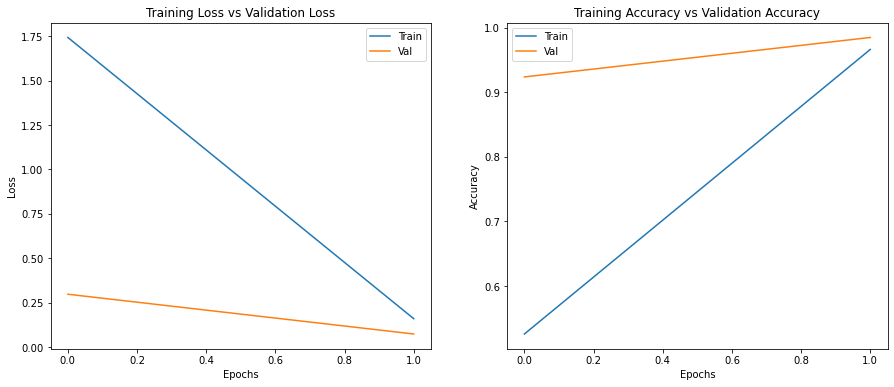

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(15,6))

axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(['Train', 'Val'])

axs[1].plot(history.history['dense_4_accuracy'])
axs[1].plot(history.history['val_dense_4_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(['Train', 'Val'])

In [26]:
GoogleNet_model.evaluate(x_test, y_test)

313/313 [==============================] - 8s 24ms/step - loss: 0.0646 - dense_4_loss: 0.0438 - dense_1_loss: 0.0583 - dense_3_loss: 0.0454 - dense_4_accuracy: 0.9864 - dense_1_accuracy: 0.9804 - dense_3_accuracy: 0.9858


[0.06457754969596863,
 0.04383651539683342,
 0.05830095708370209,
 0.04540422558784485,
 0.9864000082015991,
 0.980400025844574,
 0.98580002784729]